In [4]:
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

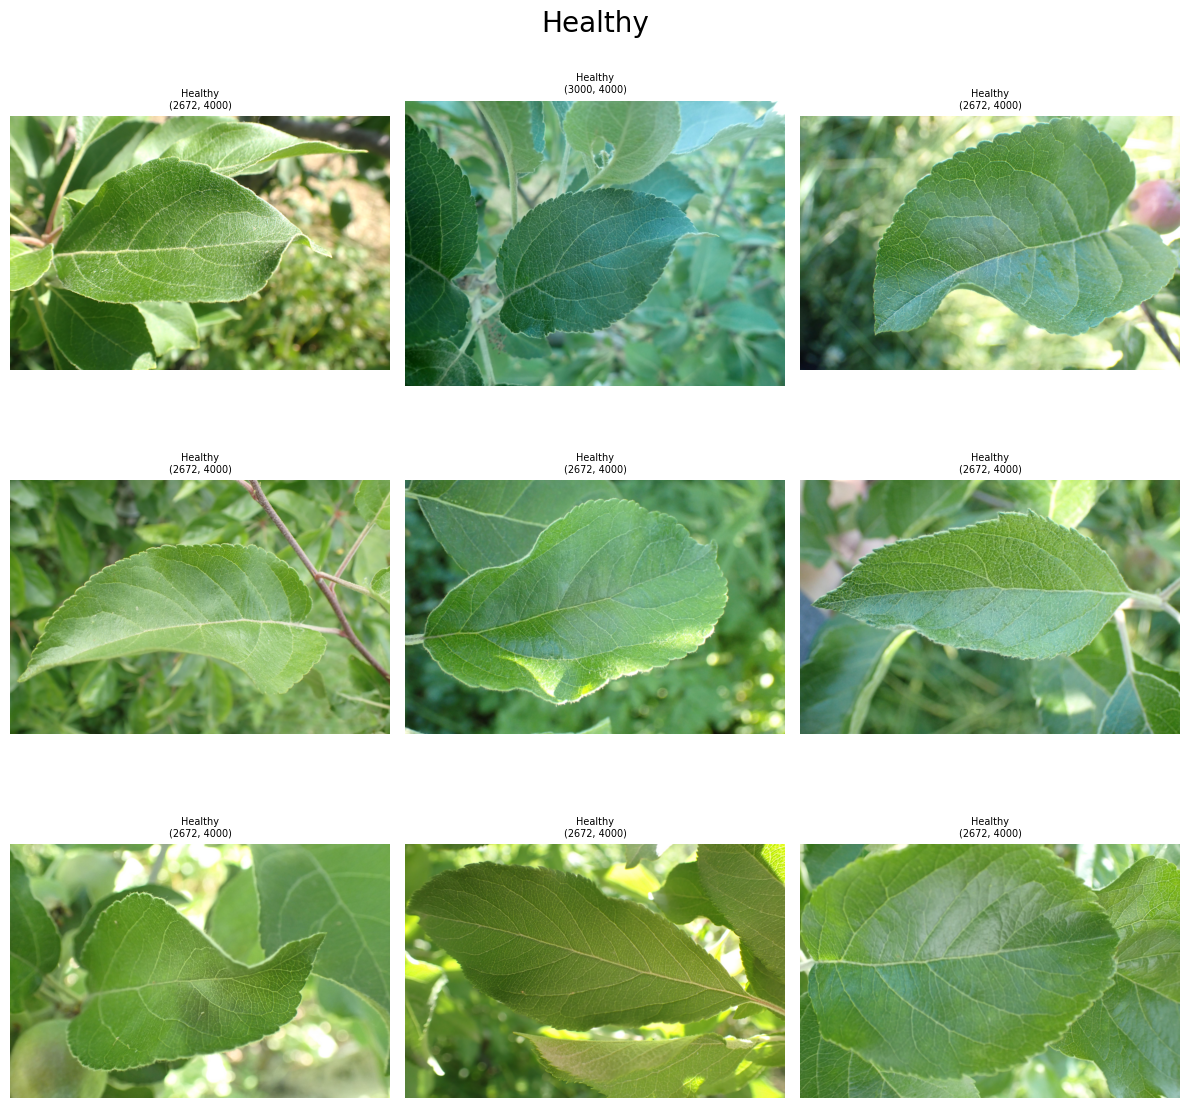

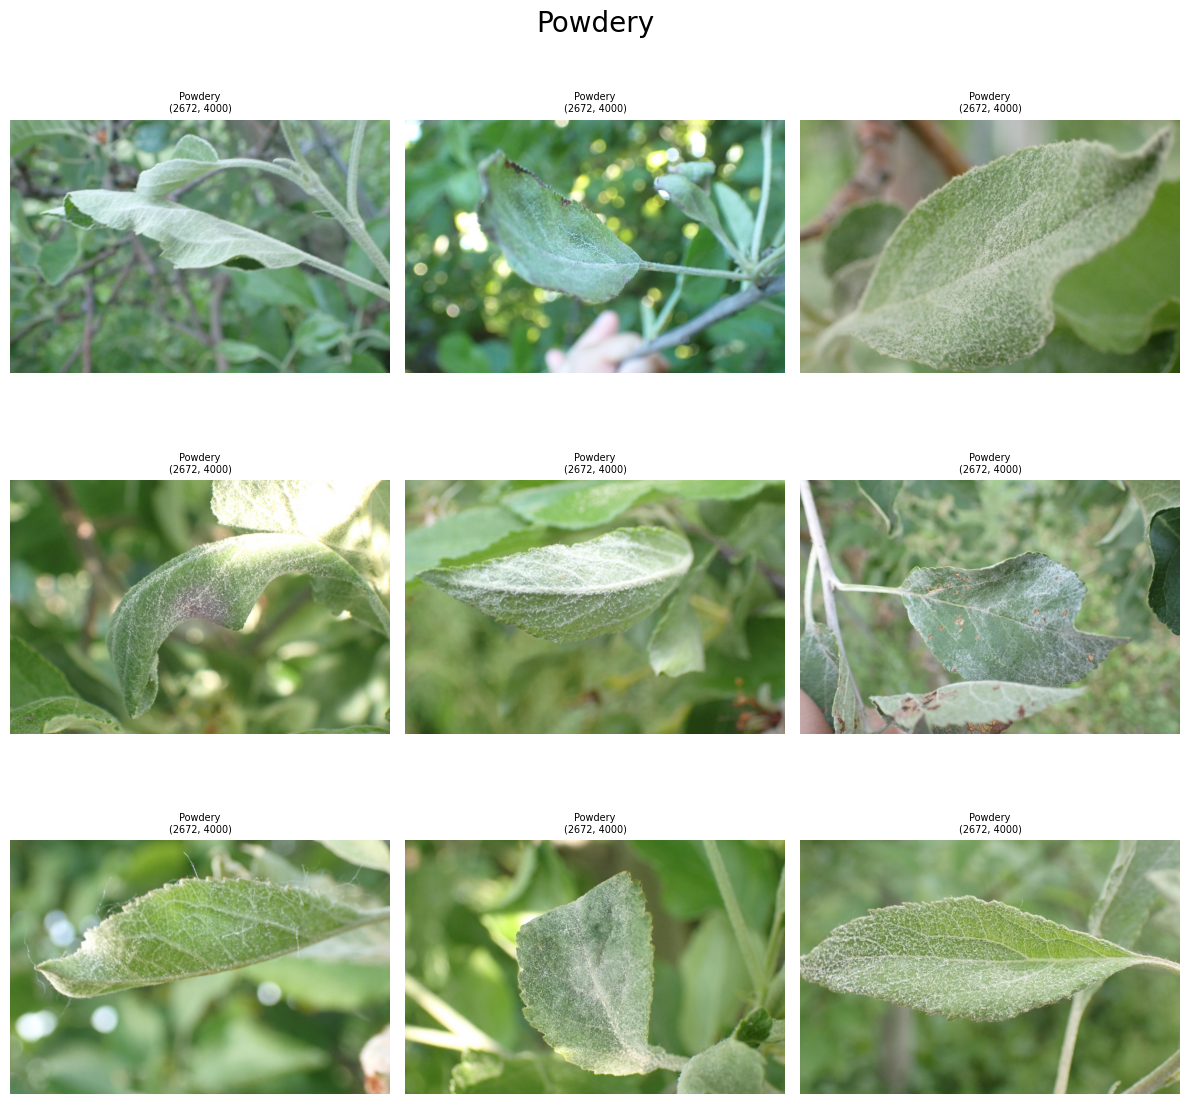

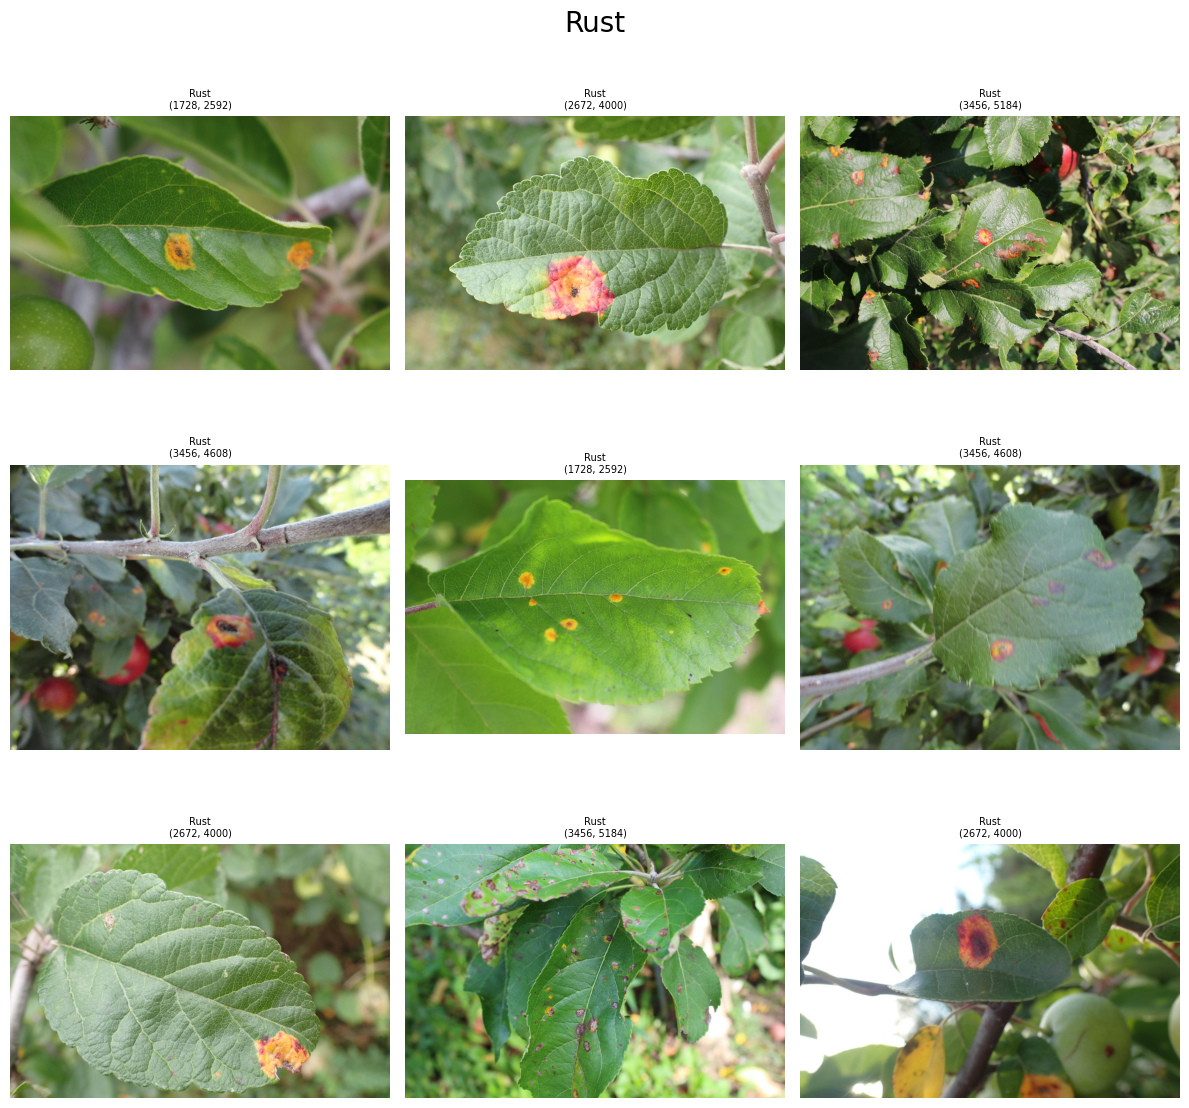

In [2]:
base_dir = "/Users/anushkaroy17/CBAM-ResGANet/kaggle_plant_detection_dataset/kaggle_dataset/Train/Train"
classes = ["Healthy", "Powdery", "Rust"]

num_images = 9

for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = os.listdir(class_path)
    
    selected_images = random.sample(images, min(num_images, len(images)))
    
    plt.figure(figsize=(12, 12))
    plt.suptitle(cls, fontsize=20)
    
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        shape_text = img.shape[:2]           
        
    
        
        plt.subplot(3, 3, i+1) 
        plt.imshow(img)
        plt.title(f"{cls}\n{shape_text}", fontsize=7)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


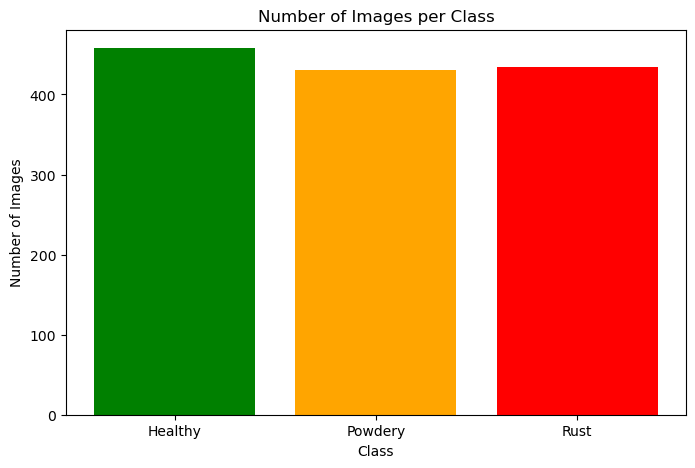

In [3]:
counts = {}
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    counts[cls] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])

plt.figure(figsize=(8,5))
plt.bar(counts.keys(), counts.values(), color=['green', 'orange', 'red'])
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [5]:
data_dir = "/Users/anushkaroy17/CBAM-ResGANet/kaggle_plant_detection_dataset/kaggle_dataset/"

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])  # ResNet normalization
])

test_val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=f"{data_dir}/Train/Train", transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=f"{data_dir}/Validation/Validation", transform=test_val_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_dir}/Test/Test", transform=test_val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes
num_classes = len(class_names)

In [6]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/anushkaroy17/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:12<00:00, 8.41MB/s]


Epoch 1/5 | Train Acc: 0.7368 | Val Acc: 0.8167
Epoch 2/5 | Train Acc: 0.8964 | Val Acc: 0.9833
Epoch 3/5 | Train Acc: 0.9418 | Val Acc: 0.9667
Epoch 4/5 | Train Acc: 0.9440 | Val Acc: 1.0000
Epoch 5/5 | Train Acc: 0.9599 | Val Acc: 1.0000


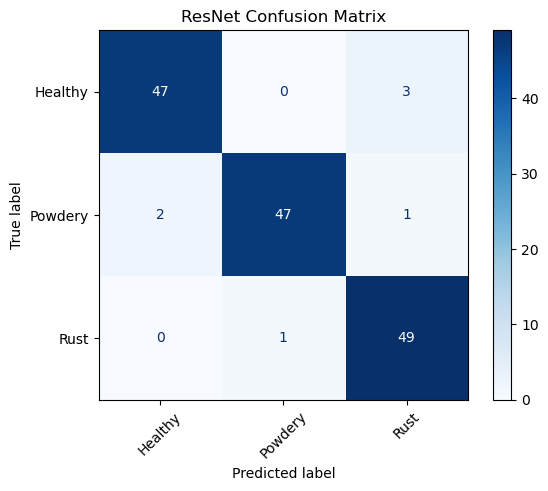

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.96      0.94      0.95        50
     Powdery       0.98      0.94      0.96        50
        Rust       0.92      0.98      0.95        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



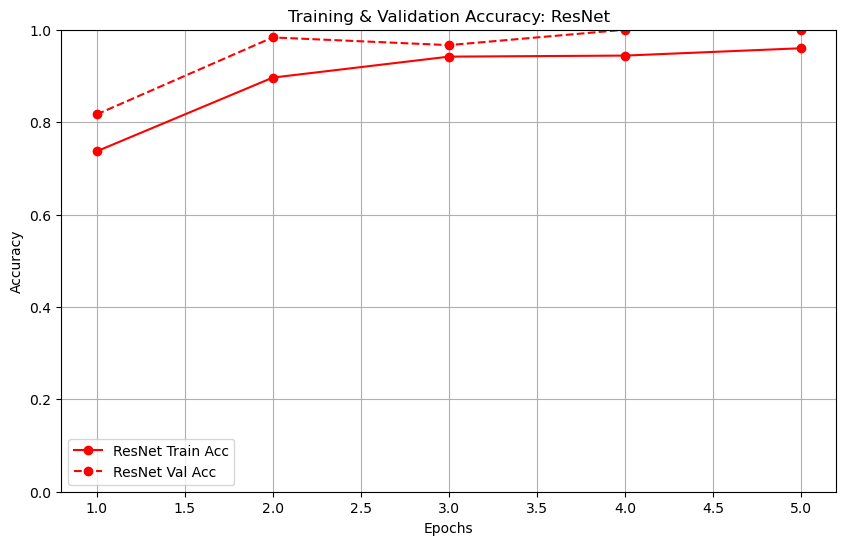

In [7]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in resnet.parameters():
    param.requires_grad = False 

resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, num_classes)
)

resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    history = {"train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history

history = train_model(resnet, criterion, optimizer, train_loader, val_loader, num_epochs=5)

resnet.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = resnet(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("ResNet Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

epochs = range(1, len(history["train_acc"]) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, history["train_acc"], 'r-o', label='ResNet Train Acc')
plt.plot(epochs, history["val_acc"], 'r--o', label='ResNet Val Acc')
plt.title("Training & Validation Accuracy: ResNet")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


In [9]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(device)

mps


Epoch 1/5 | Train Acc: 0.7746 | Val Acc: 0.9667
Epoch 2/5 | Train Acc: 0.9160 | Val Acc: 0.9667
Epoch 3/5 | Train Acc: 0.9274 | Val Acc: 0.9333
Epoch 4/5 | Train Acc: 0.9425 | Val Acc: 0.9833
Epoch 5/5 | Train Acc: 0.9501 | Val Acc: 1.0000


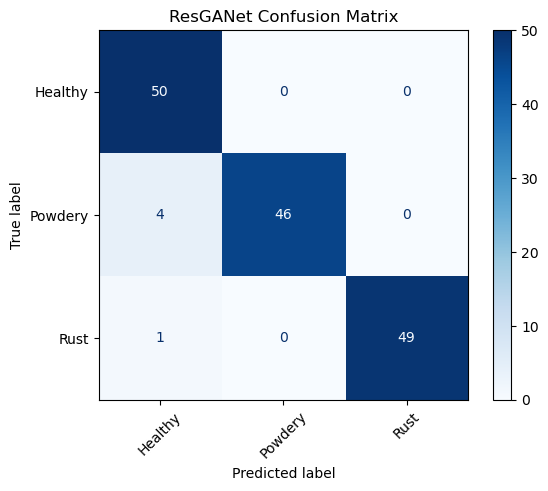

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.91      1.00      0.95        50
     Powdery       1.00      0.92      0.96        50
        Rust       1.00      0.98      0.99        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



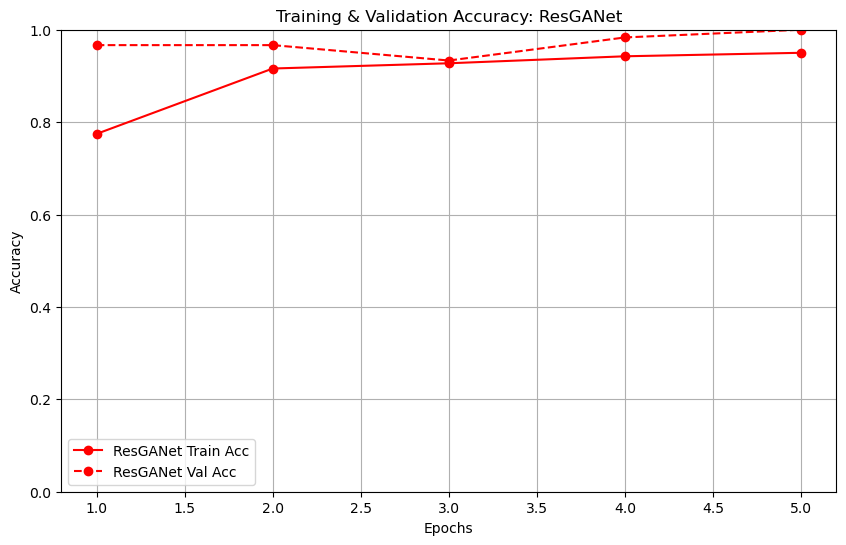

In [10]:
#ResGANet
class GlobalAttention(nn.Module):
    """
    A simple global attention block (channel-wise attention).
    Similar to SE-block but more generalizable.
    """
    def __init__(self, in_channels, reduction=16):
        super(GlobalAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


base_resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in base_resnet.parameters():
    param.requires_grad = False  

class ResGANet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(ResGANet, self).__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        in_channels = base_model.fc.in_features
        self.attention = GlobalAttention(in_channels)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.attention(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

resganet = ResGANet(base_resnet, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resganet.fc.parameters(), lr=1e-3)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    history = {"train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history

history = train_model(resganet, criterion, optimizer, train_loader, val_loader, num_epochs=5)

resganet.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = resganet(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("ResGANet Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

epochs = range(1, len(history["train_acc"]) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, history["train_acc"], 'r-o', label='ResGANet Train Acc')
plt.plot(epochs, history["val_acc"], 'r--o', label='ResGANet Val Acc')
plt.title("Training & Validation Accuracy: ResGANet")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/5 | Train Acc: 0.7716 | Val Acc: 0.9333
Epoch 2/5 | Train Acc: 0.8888 | Val Acc: 0.9333
Epoch 3/5 | Train Acc: 0.9418 | Val Acc: 0.9500
Epoch 4/5 | Train Acc: 0.9425 | Val Acc: 0.9833
Epoch 5/5 | Train Acc: 0.9418 | Val Acc: 0.9833


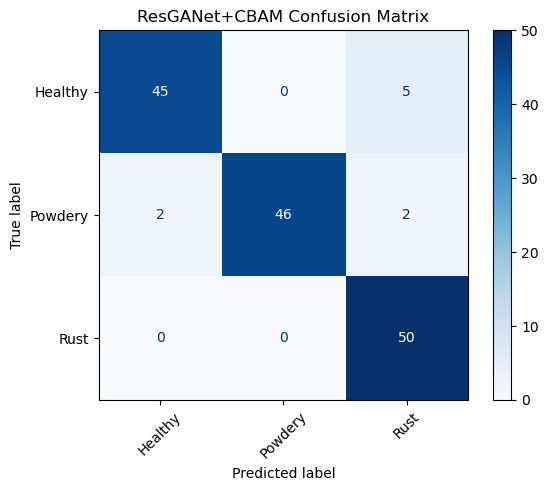

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.96      0.90      0.93        50
     Powdery       1.00      0.92      0.96        50
        Rust       0.88      1.00      0.93        50

    accuracy                           0.94       150
   macro avg       0.94      0.94      0.94       150
weighted avg       0.94      0.94      0.94       150



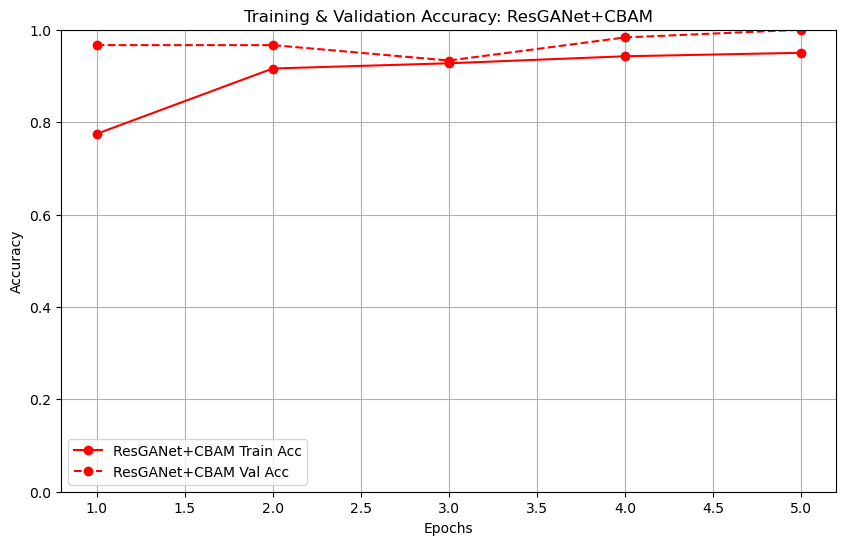

In [11]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return x * self.sigmoid(out).view(b, c, 1, 1)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)  # [B, 2, H, W]
        out = self.conv(x_cat)
        return x * self.sigmoid(out)


class CBAMBlock(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

base_resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in base_resnet.parameters():
    param.requires_grad = False

class ResGANet_CBAM(nn.Module):
    def __init__(self, base_model, num_classes):
        super(ResGANet_CBAM, self).__init__()
        self.features = nn.Sequential(*list(base_model.children())[:-2])  
        in_channels = base_model.fc.in_features
        self.cbam = CBAMBlock(in_channels)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

resganet_cbam = ResGANet_CBAM(base_resnet, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resganet_cbam.fc.parameters(), lr=1e-3)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    history = {"train_acc": [], "val_acc": []}
    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_acc = correct / total

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return history


history_cbam = train_model(resganet_cbam, criterion, optimizer, train_loader, val_loader, num_epochs=5)

resganet_cbam.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = resganet_cbam(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("ResGANet+CBAM Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

epochs = range(1, len(history["train_acc"]) + 1)
plt.figure(figsize=(10,6))
plt.plot(epochs, history["train_acc"], 'r-o', label='ResGANet+CBAM Train Acc')
plt.plot(epochs, history["val_acc"], 'r--o', label='ResGANet+CBAM Val Acc')
plt.title("Training & Validation Accuracy: ResGANet+CBAM")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

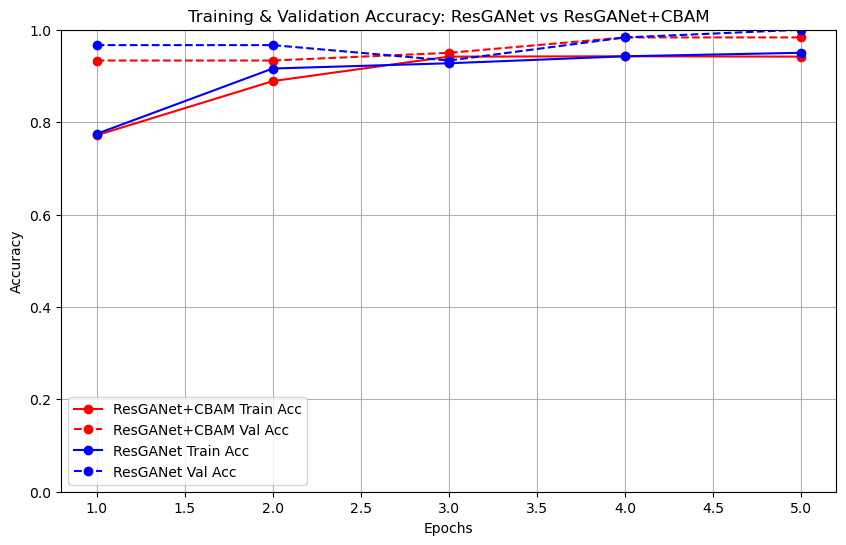

In [16]:
resganet_val_acc = history['val_acc']
resganet_train_acc = history['train_acc']


resganet_cbam_val_acc = history_cbam['val_acc']
resganet_cbam_train_acc = history_cbam['train_acc']



epochs = range(1, len(resganet_val_acc) + 1)

plt.figure(figsize=(10,6))

plt.plot(epochs, resganet_cbam_train_acc, 'r-o', label='ResGANet+CBAM Train Acc')
plt.plot(epochs, resganet_cbam_val_acc, 'r--o', label='ResGANet+CBAM Val Acc')

plt.plot(epochs, resganet_train_acc, 'b-o', label='ResGANet Train Acc')
plt.plot(epochs, resganet_val_acc, 'b--o', label='ResGANet Val Acc')

plt.title("Training & Validation Accuracy: ResGANet vs ResGANet+CBAM")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()
